<h1 style="background-color: #195365; color: #FFB703; text-align: center; padding: 15px; border-radius: 10px; box-shadow: 3px 3px 5px gray;">Python Analysis for Northwind Capstone Project</h1>


# Kütüphaneleri İmport Edelim

In [33]:
import pandas as pd
import numpy as np 
import pandas.io.sql as sqlio
import psycopg2 as ps
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
sns.set_theme(color_codes=True)
import datetime as dt 
import matplotlib.pyplot as plt 
import plotly.express as px

In [34]:
connection = ps.connect(dbname = "northwind",
                        user = "postgres",
                        password = "Nahgirme12345.",
                        port = "5432")

# CASE 1: ÜRÜN SATIŞINA GÖRE EN POPÜLER KATEGORİ ANALİZİ

**Satış ekibi, hangi kategorilerdeki ürünlerde daha fazla satış yapabileceğini analiz etmek istiyor.**

**Bu amaçla, veritabanındaki sipariş detaylarını kullanarak her kategoride en çok satan ürünü bulmak için bir sorgu yazıyorum.**

- Kategori Kimliği
- Kategori İsmi
- Ürün İsmi
- Toplam satılan ürün sayısı
- Sıralaması

In [1]:
sql1 = """
        with top_selling_category as 
(
select 
    c.category_id,
    c.category_name,
    product_name,
    sum(od.quantity) as top_selling_product,
    rank() over (partition by c.category_name order by sum(od.quantity) desc ) as rank 
from categories as c
    left join products as p
         on p.category_id=c.category_id
    left join order_details as od
         on od.product_id=p.product_id
group by 1,2,3
)
select 
    *
from top_selling_category 
where rank=1
order by top_selling_product desc
"""

In [36]:
df1 = sqlio.read_sql(sql1,connection)
df1.head(8)

,category_id,category_name,product_name,top_selling_product,rank
0,4,Dairy Products,Camembert Pierrot,1577,1
1,5,Grains/Cereals,Gnocchi di nonna Alice,1263,1
2,3,Confections,Pavlova,1158,1
3,1,Beverages,Rhönbräu Klosterbier,1155,1
4,8,Seafood,Boston Crab Meat,1103,1
5,6,Meat/Poultry,Alice Mutton,978,1
6,7,Produce,Manjimup Dried Apples,886,1
7,2,Condiments,Original Frankfurter grüne Soße,791,1


In [37]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category_id          8 non-null      int64 
 1   category_name        8 non-null      object
 2   product_name         8 non-null      object
 3   top_selling_product  8 non-null      int64 
 4   rank                 8 non-null      int64 
dtypes: int64(3), object(2)
memory usage: 448.0+ bytes


In [38]:
df1.shape

(8, 5)

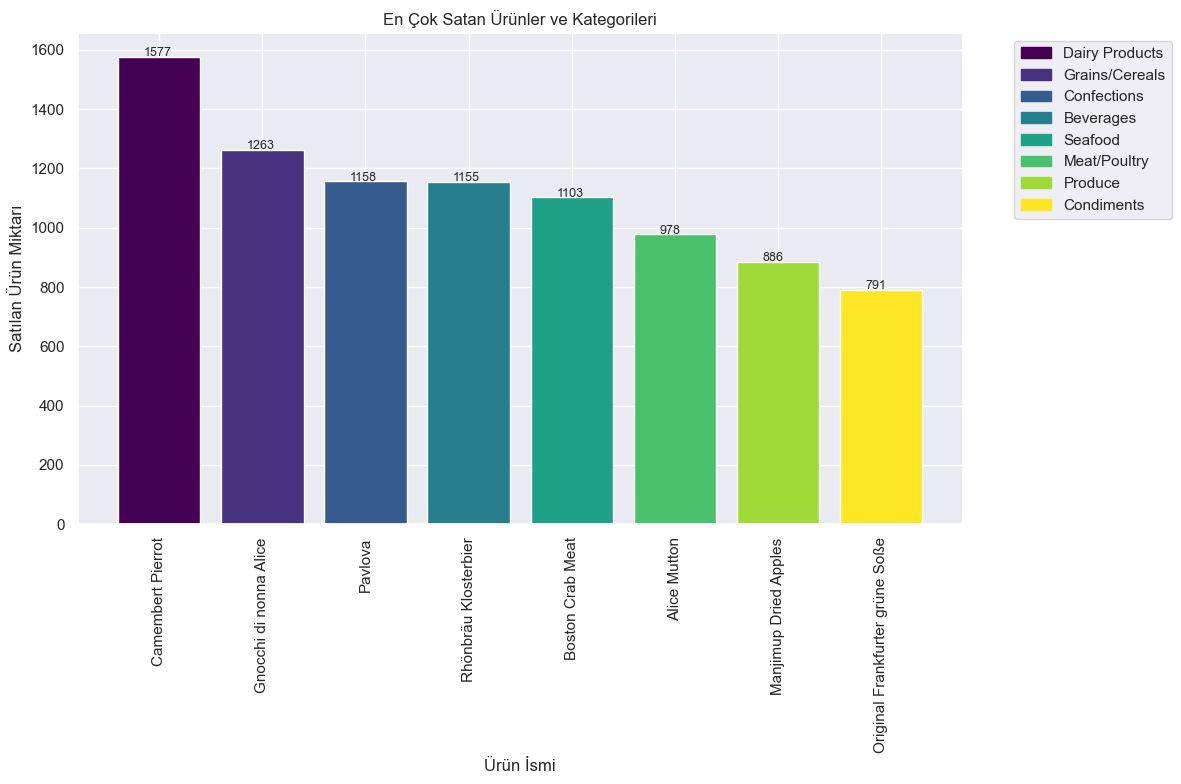

In [39]:
# Renkler: Viridis renk haritası kullanılacak
colors = plt.cm.viridis(np.linspace(0, 1, len(df1)))

# Çubuk grafik oluşturun
plt.figure(figsize=(12, 8))
bars = plt.bar(df1['product_name'], df1['top_selling_product'], color=colors)  # 'top_selling_products' yerine 'top_selling_product' kullanılmalı

plt.xticks(rotation=90)
plt.xlabel("Ürün İsmi")
plt.ylabel("Satılan Ürün Miktarı")
plt.title("En Çok Satan Ürünler ve Kategorileri")

# Kategorilere göre renk etiketleri ekleyin
color_map = dict(zip(df1["category_name"], colors))
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[category]) for category in df1["category_name"]]
plt.legend(handles, df1["category_name"], bbox_to_anchor=(1.05, 1), loc="upper left")

# Barların üzerine değerleri yazdırın
for bar, value in zip(bars, df1['top_selling_product']):  # 'top_selling_products' yerine 'top_selling_product' kullanılmalı
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, value + 1, str(value), fontsize=9)

plt.tight_layout()
plt.show()


**Görselleştirme sonucunda her kategoride en çok satan ürünü ve satış miktarını göstermektedir.Bu bilgiler doğrultusunda,
satış ekibi hangi kategorilerde ve ürünlerde daha fazla talep olduğunu anlamasına yardımcı olacaktır.Örneğin,süt ürünleri
kategorisinde Camembert Pierrot peyniri,tahıl kategorisinde Gnocchi di nonna Alice makarnası ve deniz ürünleri kategorisinde 
Boston Yengeç Eti en çok satan ürünlerdir.Bu ürünlerin stoklarını arttırmak veya fiyatlarını ayarlamak,şirketin 
karlılığını artırabilir.Ayrıca,daha az satan kategorilerde ve bu ürünlerde pazarlama stratejilerini değiştirmek yani ürün veya 
hizmetleri gözden geçirmek,dijital pazarlamayı arttırmak(sosyal medya-içerik pazarlama-web sitesi ve uygulama güncellemesi),
ürünlerin geri bildirimlerini dikkate alarak ürünler ve hizmet üzerinde iyileştirmeler yapılabilir veya yeni ürünler sunmak da 
mümkündür.**

# CASE 2 : MÜŞTERİLERİN SİPARİŞ SAYISINA GÖRE SATIŞ POTANSİYELİ ANALİZİ 

**Pazarlama ve lojistik ekibi, hangi ülkelerde ve müşterilerde daha fazla satış potansiyeli olduğunu analiz etmek istiyor.** 
**Bu analiz sonucunda,pazarlama ekibi hangi ülkelerin ve müşterilerin daha sadık ve kârlı olduğunu görebiliyor ve ve buna göre pazarlama ve lojistik stratejilerini belirleyebiliyor.**

**Bu sorgu, müşteriler, siparişler, sipariş detayları ve ürünler tablolarını birleştirerek her ülkeden en çok sipariş veren müşteriyi bulmak için kullanılır.Sorgu, her ülkede sipariş verilen ürün miktarına göre sıralama yapar ve her ülkeden en üst sırada olan müşteriyi seçer.**

- Müşteri Kimliği
- Ülke
- Sipariş Sayısı
- Sipariş Edilen Toplam Ürün Sayısı
- Toplam Miktar
- Toplam İndirim
- Müşterinin Toplam Harcaması
- Müşterinin Ortalama İstediği Teslimat Gün Sayısı
- Ortalama Teslimat Gün Sayısı 


In [40]:
sql2 = """with customers_analysis as 
(select 
	cu.customer_id,
	cu.country,
	count(distinct od.order_id) as order_number,
 	count(p.product_id) as ordered_total_product_number,
	sum(od.quantity) as total_quantity,
    round(sum(od.unit_price*od.quantity*od.discount)::numeric,2) as total_discount,
	round(sum(od.unit_price*od.quantity*(1-od.discount))::numeric,2) as customer_total_spend,
 	round(avg(o.required_date-o.order_date),0) as customer_average_wanted_days,
	round(avg(o.shipped_date-o.order_date),0) as average_delivery_time_in_days,
	rank() over(partition by cu.country order by sum(od.quantity) desc ) as rank 
from customers as cu
	left join orders as o
		on o.customer_id=cu.customer_id
	left join order_details as od 
		on od.order_id=o.order_id
	left join products as p
		on p.product_id=od.product_id
where p.discontinued=0		
group by 1,2
order by 3 desc)
select 
	customer_id,
	country,
	order_number,
	ordered_total_product_number,
	total_quantity,
	total_discount,
	customer_total_spend,
	customer_average_wanted_days,
	average_delivery_time_in_days	
from customers_analysis 
where rank=1
"""

In [41]:
df2 = sqlio.read_sql(sql2,connection)
df2.head()

,customer_id,country,order_number,ordered_total_product_number,total_quantity,total_discount,customer_total_spend,customer_average_wanted_days,average_delivery_time_in_days
0,SAVEA,USA,31,93,3963,7264.94,72513.61,28.0,9.0
1,ERNSH,Austria,30,83,3835,7002.66,89521.54,29.0,7.0
2,QUICK,Germany,27,73,3462,6074.00,97398.80,25.0,10.0
3,FOLKO,Sweden,19,41,1119,1364.61,23994.44,29.0,9.0
4,HUNGO,Ireland,19,44,1377,4122.04,27867.65,29.0,11.0


In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    21 non-null     object 
 1   country                        21 non-null     object 
 2   order_number                   21 non-null     int64  
 3   ordered_total_product_number   21 non-null     int64  
 4   total_quantity                 21 non-null     int64  
 5   total_discount                 21 non-null     float64
 6   customer_total_spend           21 non-null     float64
 7   customer_average_wanted_days   21 non-null     float64
 8   average_delivery_time_in_days  21 non-null     float64
dtypes: float64(4), int64(3), object(2)
memory usage: 1.6+ KB


In [43]:
df2.shape

(21, 9)

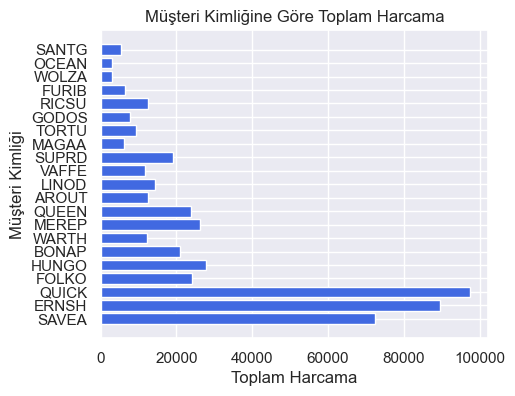

In [44]:
plt.figure(figsize=(5, 4))
plt.barh(df2["customer_id"], df2["customer_total_spend"], color='royalblue')
plt.ylabel("Müşteri")
plt.xlabel("Toplam Harcama")
plt.title("Müşteriye Göre Toplam Harcama")
plt.show()

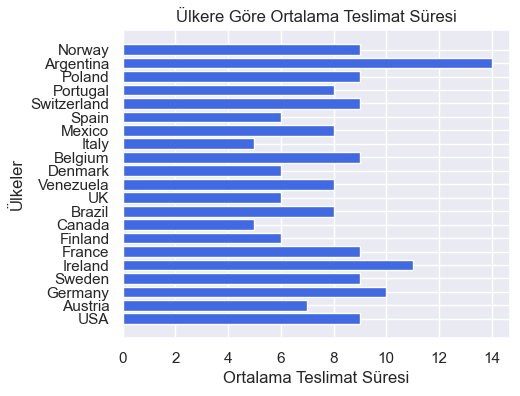

In [45]:
plt.figure(figsize=(5, 4))
plt.barh(df2["country"], df2["average_delivery_time_in_days"], color='royalblue')
plt.ylabel("Ülkeler")
plt.xlabel("Ortalama Teslimat Süresi")
plt.title("Ülkere Göre Ortalama Teslimat Süresi")
plt.show()

**Hangi ülkelerde ve müşterilerde daha fazla satış potansiyeli olduğunu görmek içinn yukarıdaki 2 görselleştirmeyi yaptım.Örneğin ABD'den SAVEA müşterisi,31 sipariş ile en çok sipariş veren müşteridir.Bu müşteri,toplam 3963 adet ürün sipariş etmişve 72513.61 $ harcamıştır.Bu müşteri,ortalama 28 gün içinde siparişlerinin istemekte ve 9 gün içinde teslim alabilmektedir.Bu müşterinin sadakatini korumak ve arttırmak için şirket özel indirimler,hediye çekleri veya ücretsiz kargo gibi teklifler sunabilir.Ayrıca,teslim süresini kısaltmak ve müşteri hizmet kalitesini arttırmak için lojistik operasyonlarını iyileştirebilir**

**Benzer şekilde, diğer ülkelerden en çok sipariş veren müşteriler de analiz edilebilir. Hangi ülkelerin ve müşterilerin daha fazla indirim aldığını, daha fazla harcama yaptığını, daha fazla veya daha az teslim süresi beklediğini görmek mümkündür. Bu bilgiler, şirketin pazarlama ve lojistik stratejilerini belirlemesine yardımcı olabilir.Müşteri verilerini kullanarak kişiselleştirilmiş pazarlama kampayaları oluşturarak özelleştirilmiş teklifler ve iletişimlerle müşteri bağlılığını arttırılabilir.**



In [46]:
corr = df2.corr()

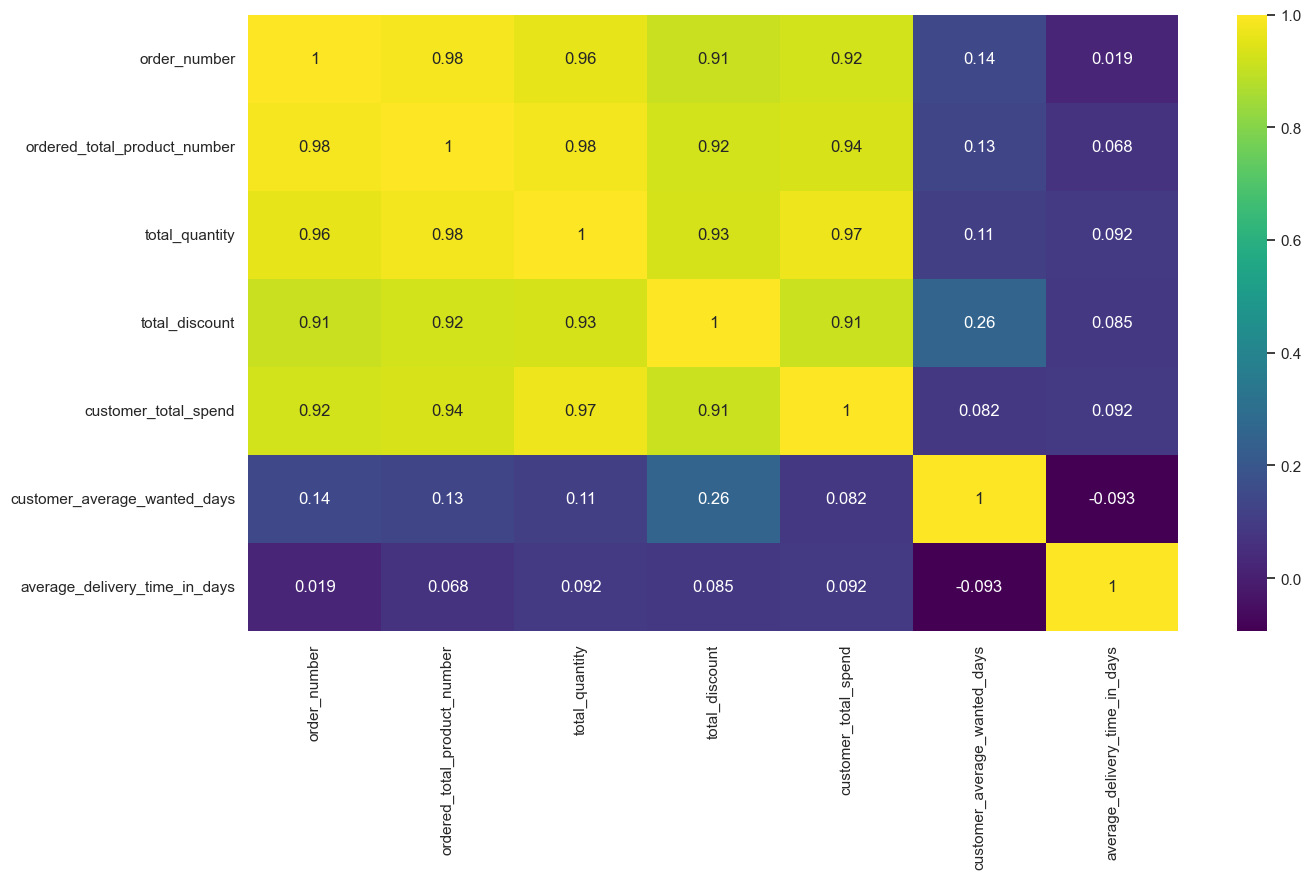

In [47]:
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, cmap='viridis');

**-0.093 değeri sıfıra çok yakın olduğu için, bu iki sütun arasında çok zayıf bir negatif ilişki olduğunu söyleyebiliriz. Yani, müşterilerin ortalama istedikleri gün sayısı ile ortalama teslimat süresi günleri arasında negatif bir ilişki gibi görünüyor, ancak bu ilişki çok zayıf ve istatistiksel olarak anlamsız olabilir. Başka değişkenler veya faktörler, bu iki değişken arasındaki ilişkiyi daha fazla etkileyebilir. Örneğin, korelasyon grafiğine tekrar baktığımızda, müşterilerin toplam harcamalarının teslimat süreleri üzerinde güçlü bir pozitif doğrusal ilişki gösterdiğini görüyoruz.**

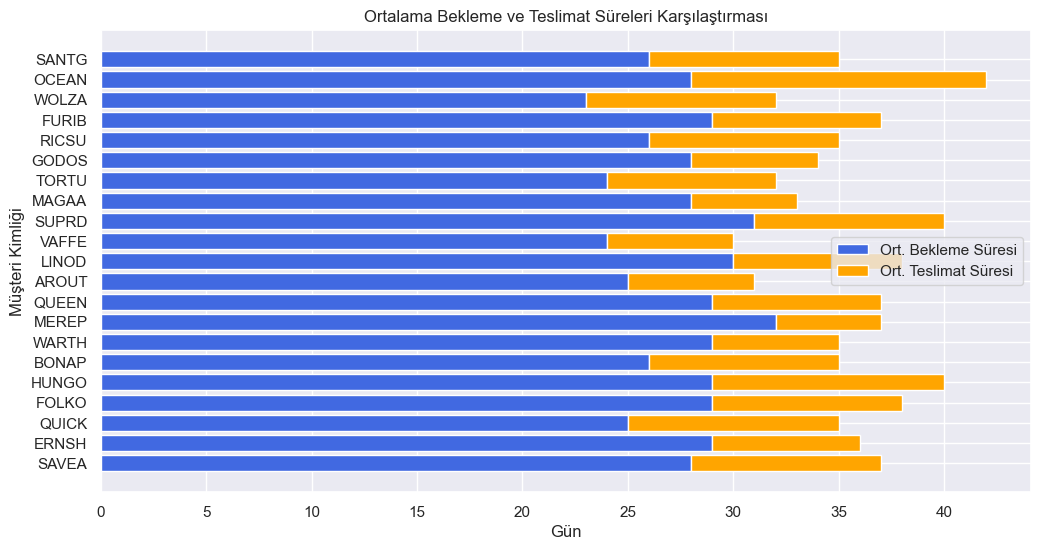

In [48]:
# Verilerinizi ve etiketlerinizi hazırlayın
customer_ids = df2["customer_id"]
average_wanted_days = df2["customer_average_wanted_days"]
average_delivery_days = df2["average_delivery_time_in_days"]

# Çubuk grafik oluşturma
plt.figure(figsize=(12, 6))
plt.barh(customer_ids, average_wanted_days, color='royalblue', label='Ort. Bekleme Süresi', align='center')
plt.barh(customer_ids, average_delivery_days, color='orange', left=average_wanted_days, label='Ort. Teslimat Süresi', align='center')
plt.xlabel('Gün')
plt.ylabel('Müşteri Kimliği')
plt.title('Ortalama Bekleme ve Teslimat Süreleri Karşılaştırması')
plt.legend()
plt.show()

**Grafiğe bakıldığında,müşterilerin ortalama olarak istedikleri teslimat süresi(28-32 gün) gerçek teslimat süresinden (5-14 gün) daha uzun görünüyor.Bu,müşterilerin ürünlerini daha hızlı almayı tercih ettiğini ve işletmenin bu beklentiyi karşılamak için daha fazla çaba göstermesi gerektiğini gösteriyor.Grafikten anlaşılacağı üzere teslimat sürelerini müşteri beklentilerine daha yakın hale getirerek müşteri memnuniyetinin arttığını söyleyebiliriz.Daha iyi bir hizmet sunmak için lojistik operasyoları ve sipariş yönetim süreçleri gözden geçirilerek iyileştirmek önemlidir.Sonuç olarak işletmenin teslimat sürelerinin performansını değerlendirmek ve daha iyi hizmet sunmak için yol gösterici olabilir.**


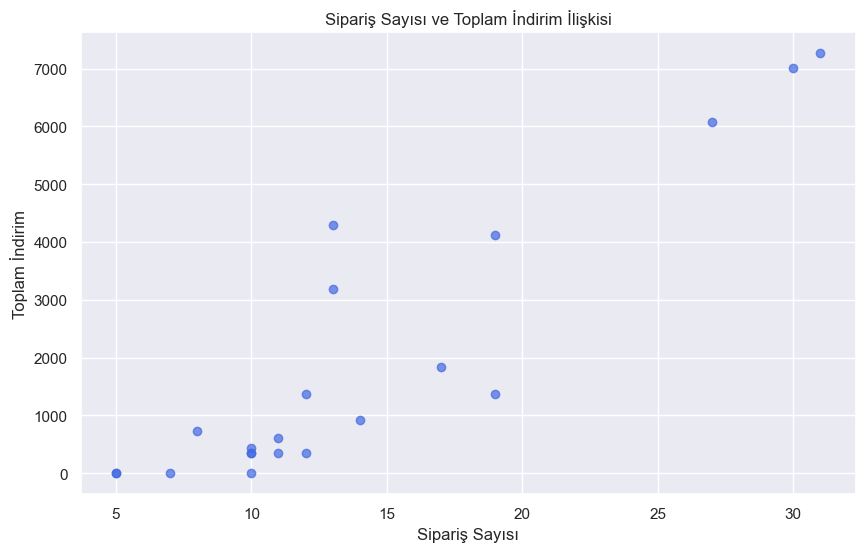

In [49]:
# Verilerinizi hazırlayın
order_numbers = df2["order_number"]
total_discounts = df2["total_discount"]

# Saçılım (scatter) grafiği oluşturma
plt.figure(figsize=(10, 6))
plt.scatter(order_numbers, total_discounts, color='royalblue', alpha=0.7)
plt.xlabel('Sipariş Sayısı')
plt.ylabel('Toplam İndirim')
plt.title('Sipariş Sayısı ve Toplam İndirim İlişkisi')
plt.grid(True)
plt.show()

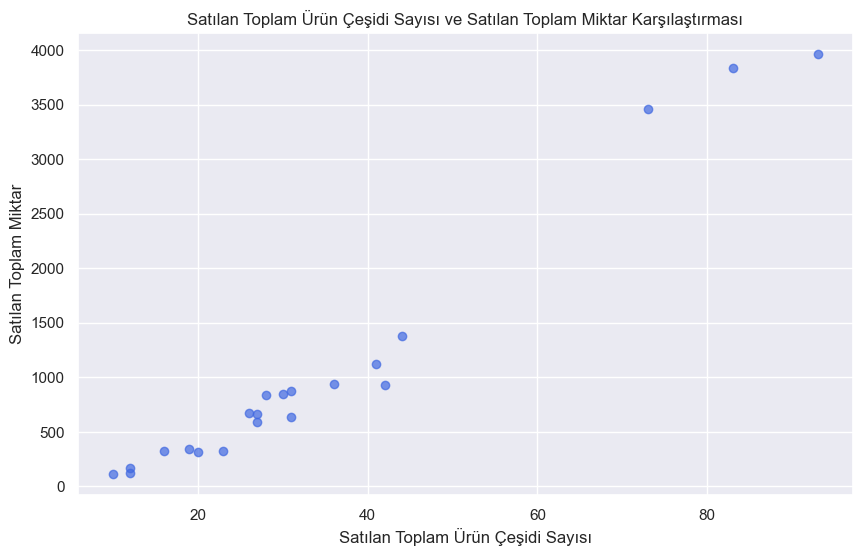

In [50]:
# Verilerinizi hazırlayın
total_product_numbers = df2["ordered_total_product_number"]
total_quantities = df2["total_quantity"]

# Saçılım (scatter) grafiği oluşturma
plt.figure(figsize=(10, 6))
plt.scatter(total_product_numbers, total_quantities, color='royalblue', alpha=0.7)
plt.xlabel('Satılan Toplam Ürün Çeşidi Sayısı')
plt.ylabel('Satılan Toplam Miktar')
plt.title('Satılan Toplam Ürün Çeşidi Sayısı ve Satılan Toplam Miktar Karşılaştırması')
plt.grid(True)
plt.show()

# CASE 3 : Nakliyecilerin Performans Analizi

**Lojistik ekibi, farklı nakliyecilerin performansını analiz etmek istiyor.**

**Sipariş detaylarını kullanarak her nakliyeci için toplam sipariş sayısı, ortalama kargo ücreti ve ortalama kargo süresini bulmak için bir sorgu yazdım. Sorgu sonucunda, online alışveriş sitesi hangi nakliyecinin daha hızlı, daha ucuz ve daha çok sipariş taşıdığını görebiliyor ve buna göre nakliye anlaşmalarını yenileyebiliyor. Örneğin, sorgu sonucunda Speedy Express’in en hızlı nakliyeci olduğunu, ancak United Package’in en çok sipariş taşıdığını görebiliriz.**

- nakliyeci kimliği
- nakliyeci şirket adı
- toplam sipariş sayısı
- ortalama kargo ücreti 
- ortalama kargo süresi 

In [51]:
sql3="""select 
    s.shipper_id,
    s.company_name,
    count(distinct o.order_id) as total_orders,
    round(avg(o.freight)::numeric,2) as avg_freight,
    round(avg(extract(day from (o.shipped_date - o.order_date) * interval '1 DAY'))::numeric,0) as avg_shipping_days		
from 
	shippers as s
left join orders as o 
	on s.shipper_id = o.ship_via
group by 
    s.shipper_id, s.company_name;
"""

In [52]:
df3 = sqlio.read_sql(sql3,connection)
df3.head()

,shipper_id,company_name,total_orders,avg_freight,avg_shipping_days
0,1,Speedy Express,249,65.00,9.0
1,2,United Package,326,86.64,9.0
2,3,Federal Shipping,255,80.44,7.0
3,4,Alliance Shippers,0,NaN,NaN
4,5,UPS,0,NaN,NaN


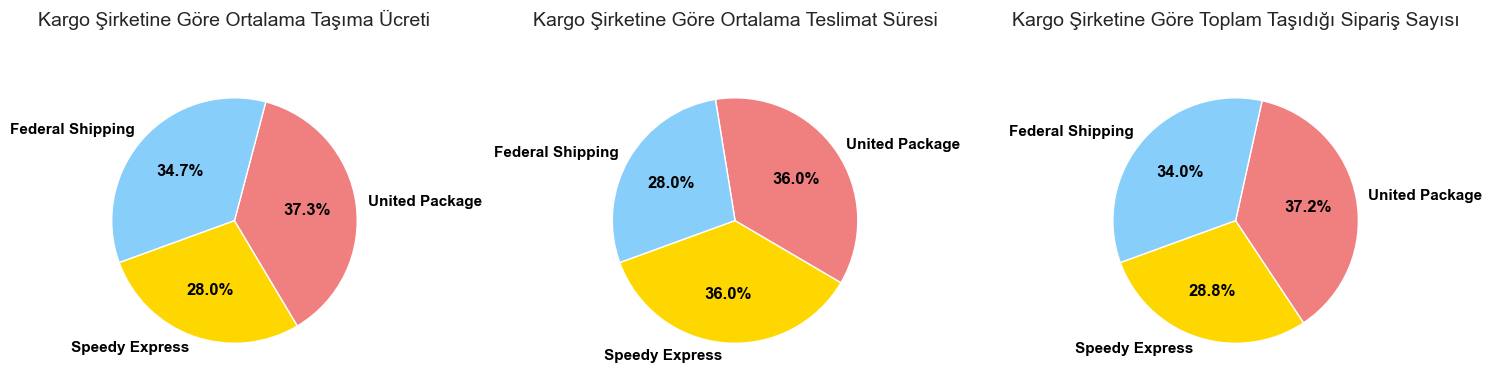

In [53]:
# NaN değerleri temizle
df3.dropna(subset=["avg_freight", "avg_shipping_days"], inplace=True)

# Verilerinizi hazırlayın
non_zero_freight = df3["avg_freight"]
non_zero_shipping_days = df3["avg_shipping_days"]
company_names = df3["company_name"]

# Renkleri belirleyin
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']

# Pasta grafiği oluşturma
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

# 1. Pasta Grafiği: avg_freight
axs[0].pie(non_zero_freight, labels=company_names, autopct='%1.1f%%', startangle=200, colors=colors, textprops={'color': 'black', 'weight': 'bold'})
axs[0].set_title('Kargo Şirketine Göre Ortalama Taşıma Ücreti', fontsize=14, pad=30)

# 2. Pasta Grafiği: avg_shipping_days
axs[1].pie(non_zero_shipping_days, labels=company_names, autopct='%1.1f%%', startangle=200, colors=colors, textprops={'color': 'black', 'weight': 'bold'})
axs[1].set_title('Kargo Şirketine Göre Ortalama Teslimat Süresi', fontsize=14, pad=30)

# 3. Pasta Grafiği: Toplam Hesaplanan Pasta Grafiği
total_values = non_zero_freight + non_zero_shipping_days
axs[2].pie(total_values, labels=company_names, autopct='%1.1f%%', startangle=200, colors=colors, textprops={'color': 'black', 'weight': 'bold'})
axs[2].set_title('Kargo Şirketine Göre Toplam Taşıdığı Sipariş Sayısı', fontsize=14, pad=30)

# Grafiği göster
plt.tight_layout()
plt.show()

**Speedy Express'in ortalama kargo ücretinin düşük olduğu için ekonomik bir nakliyeci olarak değerlendirebiliriz.**

**United Package ortalama kargo ücreti ve ortalama kargo süresi olarak diğer nakliyecilere göre biraz daha yüksek görünüyor.Ancak toplam sipariş sayısına bakarsak bu nakliye şirketinin büyük hacimde taşıma sağladığını söyleyebiliriz.**

**Federal Shipping ise ortalama kargo süresi açısından diğer şirketlere göre daha hızlı olduğunu söyleyebiliriz.Yani müşteriler için hızlı teslimat yapma avantajı sağlayabilir.**

# CASE 4 : AYLARA GÖRE GELİR ANALİZİ

**Satış ekibi, son üç yılın her ay için gelir performansını analiz etmek istiyor. Bu amaçla, veritabanındaki sipariş detaylarını kullanarak her ay için toplam geliri ve toplam kargo ücretini bulmak için bir sorgu yazdım.**

- sipariş ayı
- kargo ücreti çıkarılmış gelir
- bir önceki ayın kargo ücreti çıkarılmış geliri 
- kargo ücreti çıkarılmış gelirdeki büyüme oranı 

In [54]:
sql4="""
with revenue_by_month as (
    select
        extract(month from o.order_date) as order_month,
        round(sum(od.unit_price * od.quantity * (1 - od.discount))::numeric, 2) as total_revenue
    from
        orders o
    inner join order_details as od 
		on o.order_id = od.order_id
    group by
        order_month
    order by
        order_month
),
freight_by_month as (
    select
        extract(month from o.order_date) as order_month,
        round(sum(o.freight)::numeric, 2) as total_freight_price
    from
        orders o
    group by
        order_month
    order by
        order_month
)
select
   rm.order_month,
   rm.total_revenue - fm.total_freight_price as total_revenue_after_freight,
   lag(rm.total_revenue - fm.total_freight_price) over (order by rm.order_month) as previous_month_revenue_after_freight,
   round((rm.total_revenue - fm.total_freight_price - lag(rm.total_revenue - fm.total_freight_price) 
   over (order by rm.order_month))::numeric / 
   lag(rm.total_revenue - fm.total_freight_price) over (order by rm.order_month)::numeric * 100,2) as revenue_growth_rate_after_freight
from
    revenue_by_month as rm
inner join  freight_by_month as fm 
	on rm.order_month = fm.order_month;


"""

In [55]:
df4 = sqlio.read_sql(sql4,connection)
df4.head(12)

,order_month,total_revenue_after_freight,previous_month_revenue_after_freight,revenue_growth_rate_after_freight
0,1.0,147777.76,NaN,NaN
1,2.0,132024.53,147777.76,-10.66
2,3.0,136133.55,132024.53,3.11
3,4.0,167498.96,136133.55,23.04
4,5.0,67968.44,167498.96,-59.42
5,6.0,34510.15,67968.44,-49.23
6,7.0,75135.85,34510.15,117.72
7,8.0,68297.50,75135.85,-9.10
8,9.0,77650.11,68297.50,13.69
9,10.0,98798.83,77650.11,27.24


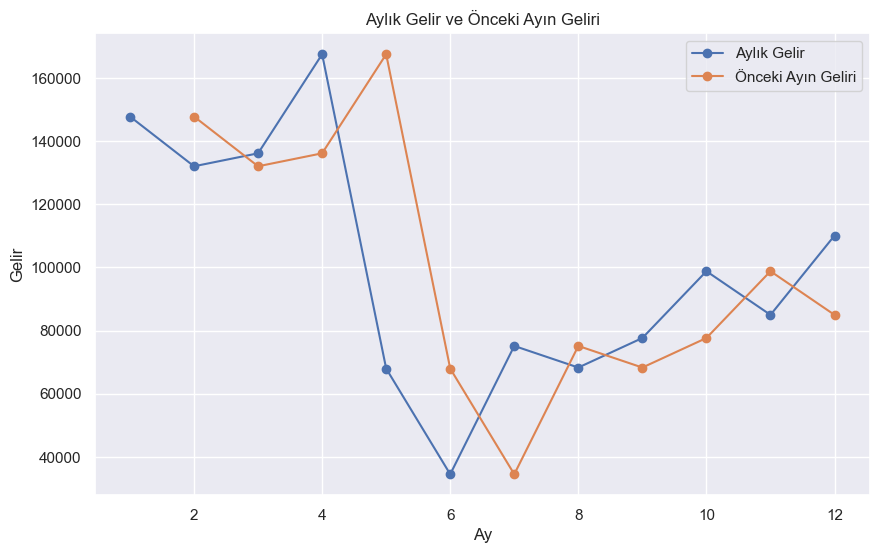

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(df4['order_month'], df4['total_revenue_after_freight'], marker='o', label='Aylık Gelir')
plt.plot(df4['order_month'], df4['previous_month_revenue_after_freight'], marker='o', label='Önceki Ayın Geliri')
plt.xlabel('Ay')
plt.ylabel('Gelir')
plt.title('Aylık Gelir ve Önceki Ayın Geliri')
plt.legend()
plt.grid(True)
plt.show()